# Country Data Trends
## Raw Data

This notebook will investigate periodic trends in Covid-19 case and death data, primarily in the UK. All data taken from the [John Hopkins Database](https://coronavirus.jhu.edu/about).

In [146]:
import re
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '12'

import plotnine as pn
from plotnine import ggplot, geom_point, geom_line, aes

In [111]:
# Import/Generate Data

from country_data import generate_location_df

input_dir = "../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/"
output_dir = "../data/"
location_key = "England, United Kingdom"
location = re.sub('\W+','',location_key)

# country_df = generate_location_df(input_dir, location_key)
# country_df.to_csv(output_dir + re.sub('\W+','',location_key) + ".csv")

df = pd.read_csv(output_dir + location + ".csv")
df["Date"] = pd.to_datetime(df["Date"], format = "%Y-%m-%d")
df.sort_values(by="Date", inplace=True)
print(df.columns.values)

['Unnamed: 0' 'Province_State' 'Country_Region' 'Last_Update' 'Lat'
 'Long_' 'Confirmed' 'Deaths' 'Recovered' 'Active' 'Combined_Key'
 'Incident_Rate' 'Case_Fatality_Ratio' 'Date']


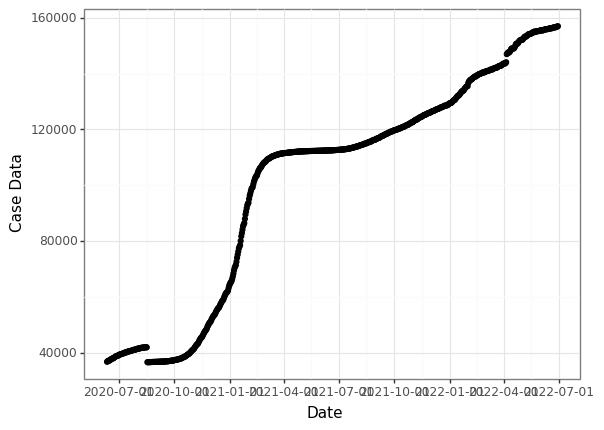

In [112]:
# Transform raw date data into useful format

date_plot = (ggplot(df, aes(x='Date', y='Deaths'))
             + geom_point() + pn.theme_bw()
             + pn.labels.ylab('Case Data'))

# date_plot.save(filename=f"../images/data_trends/case_data_{location}")
print(date_plot)


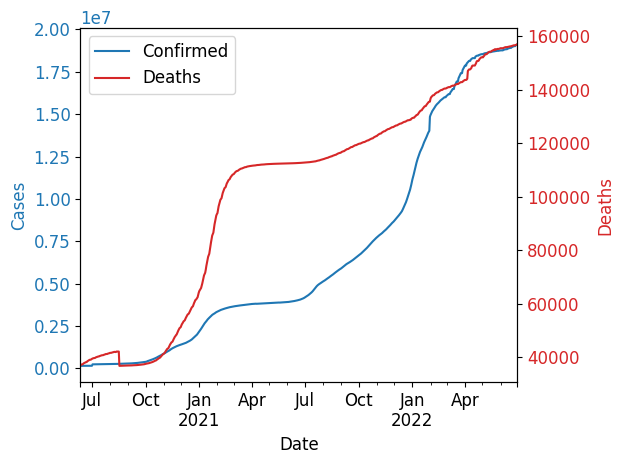

In [147]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Cases', color=color)
plot1 = df.plot.line('Date', 'Confirmed', ax=ax1, color=color, legend=False)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Deaths', color=color)
plot2 = df.plot.line('Date', 'Deaths', ax=ax2, color=color, legend=False)
ax2.tick_params(axis='y', labelcolor=color)

lines = [plot.lines[0] for plot in [plot1, plot2]]
labels = [l.get_label() for l in lines]
plt.legend(lines, labels)
fig.tight_layout()
plt.savefig(f"../images/data_trends/cumulative_data_{location}.png")

## Daily Data

Plot the daily reported cases and data, flagging inconsistencies in the data (when either cumulative value drops).

In [117]:
df["Daily_Deaths"] = df["Deaths"].diff()
df["Daily_Cases"] = df["Confirmed"].diff()

print(str((df["Daily_Deaths"] < 0).sum()) + " negative values in death record")
print(str((df["Daily_Cases"] < 0).sum()) + " negative values in cases record")

df[["Daily_Deaths","Daily_Cases"]] = df[["Daily_Deaths","Daily_Cases"]].clip(lower = 0)

3 negative values in death record
3 negative values in cases record


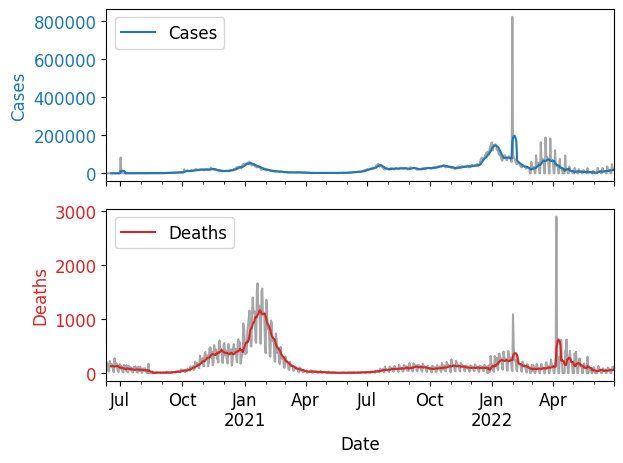

In [148]:
def plot_daily_panel(df, column, ax, color, label, weekly_ave = True):
    ax.set_ylabel(label, color=color)
    plot = df.plot.line('Date', column, ax=ax, color='gray', label='', alpha=0.7)
    if weekly_ave:
        ax.plot(df['Date'], df[column].rolling(7, win_type='gaussian').mean(std=4),
                color=color, label=label)
    ax.tick_params(axis='y', labelcolor=color)
    ax.legend(loc=2)
    return plot
    
fig, axs = plt.subplots(2)

plot_daily_panel(df, 'Daily_Cases', ax=axs[0], color='tab:blue', label="Cases")
axs[0].set_xlabel(''); axs[0].set_xticklabels([])

plot_daily_panel(df, 'Daily_Deaths', ax=axs[1], color='tab:red', label="Deaths")

fig.tight_layout()
plt.savefig(f"../images/data_trends/daily_data_{location}.png")

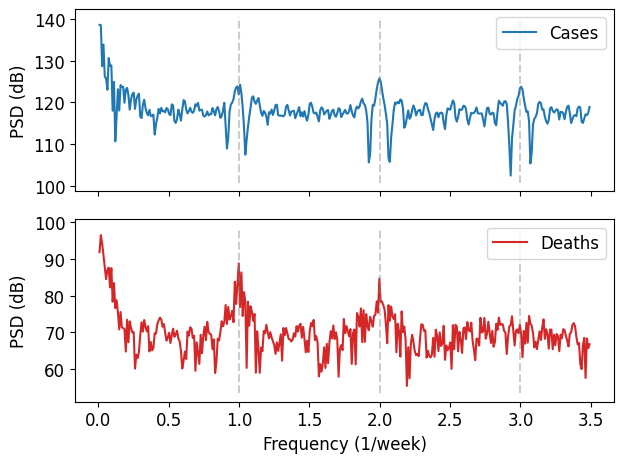

In [214]:
# Plot Fourier components of case data

df["Days"] = df["Date"].apply(lambda date: (date - min(df["Date"])).days)

def fourier_transform(df, column, compute_psd = False):
    data = df[column].fillna(0).values
    data_fft = sp.fftpack.fft(data)
    data_psd = np.abs(data_fft) ** 2  # Power Spectral density

    fftfreq = sp.fftpack.fftfreq(len(data_fft), 1/7)  # Frequency units in weeks
    return (data_psd, fftfreq) if compute_psd else (data_fft, fftfreq)

def plot_fft(data, freq, ax, color, label):
    i = freq > 0  # Remove negative frequencies
    ax.plot(freq[i], 10 * np.log10(data[i]), color=color, label=label)
    y_lim = ax.get_ylim()
    ax.vlines([(n+1) for n in range(3)], y_lim[0], y_lim[1],
              colors='gray', linestyles='dashed', alpha=0.4)
    ax.set_xlabel('Frequency (1/week)')
    ax.set_ylabel('PSD (dB)')
    ax.legend(loc=1)

fig, axs = plt.subplots(2)

case_fft, case_freq = fourier_transform(df, column='Daily_Cases', compute_psd=True)
plot_fft(case_fft, case_freq, ax=axs[0], color='tab:blue', label="Cases")
axs[0].set_xlabel(''); axs[0].set_xticklabels([])

death_fft, death_freq = fourier_transform(df, column='Daily_Deaths', compute_psd=True)
plot_fft(death_fft, death_freq, ax=axs[1], color='tab:red', label="Deaths")

fig.tight_layout()
plt.savefig(f"../images/data_trends/daily_fft_{location}.png")


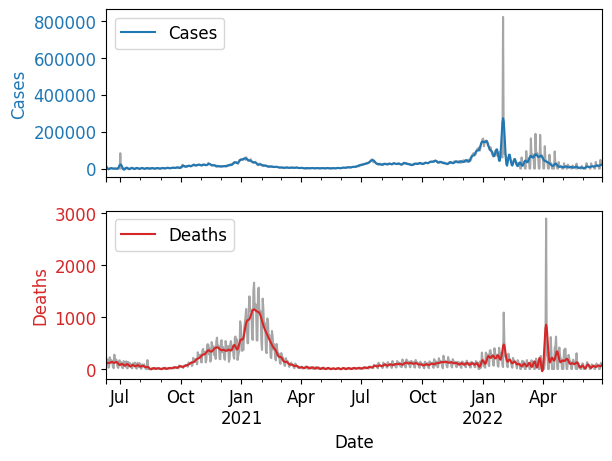

In [213]:
# Data with High freq components removed
def plot_ifft(df, column, cutoff, ax, color, label):
    data_fft, data_freq = fourier_transform(df, column=column, compute_psd=False)
    data_crop_fft = data_fft.copy()
    data_crop_fft[np.abs(data_freq) > cutoff] = 0
    data_crop = np.real(sp.fftpack.ifft(data_crop_fft))
    df.plot.line('Date', column, color='gray', ax=ax, label='', alpha=0.7, legend=False)
    ax.plot(df['Date'], data_crop, color=color, label=label)
    ax.legend(loc=2); ax.set_ylabel(label, color=color)
    ax.tick_params(axis='y', labelcolor=color)

fig, axs = plt.subplots(2)
cutoff = 0.9

plot_ifft(df, 'Daily_Cases', cutoff=cutoff, ax=axs[0], color='tab:blue', label="Cases")
plot_ifft(df, 'Daily_Deaths', cutoff=cutoff, ax=axs[1], color='tab:red', label="Deaths")
axs[0].set_xlabel(''); axs[0].set_xticklabels([]);
plt.savefig(f"../images/data_trends/daily_ifft_{location}_cutoff{cutoff}.png")
